# Durban Port Congestion Simulation
### **Discrete event simulation of Crane Scheduling & Yard Dwell Time**

This notebook models the flow of containers through the Durban Container Terminal using a Discrete Event Simulation (DES) approach.
The goal is to:

- Identify bottlenecks
- Model realistic delays
- Test optimisation strategies such as:
    1. Crane Scheduling Optimisation
    2. Yard Dwell Time Reduction

This notebook is structured to reflect the real-world operations of Durban Port, including:

- Offloading by STS cranes
- Yard capacity constraints
- Scanning delays (SARS)
- Truck loading
- Gate-out processing

We will build the simulation step-by-step, with explanations for each block.

In [1]:
import simpy
import random
import numpy as np
import pandas as pd

Listed above, are the core libraries for our simulation:
- simpy : Discrete event simulation engine
- random : Stochastic arrival patterns
- numpy : numerical operations
- pandas : storing and analysing the results

This is the minimal set we need to start building our model.

In [2]:
# -----------------------------
# Global Parameters (Week 1 Data + Realistic Behaviour Enhancements)
# -----------------------------

# Cranes (STS)
NUM_CRANES = 16         
CRANE_MOVES_PER_HOUR = 18   
CRANE_TIME = 60 / CRANE_MOVES_PER_HOUR  

# Yard
YARD_CAPACITY = 10000  

# Scanners (SARS)
NUM_SCANNERS = 2    
SCAN_TIME = 10       # fixed scanning time (we keep this deterministic)

# --------------------------------------------------------
# Truck Loading (realistic: fewer bays + variable service)
# --------------------------------------------------------
NUM_LOADING_BAYS = 2     # reduced to induce realistic queueing

import random

def sample_loading_time():
    # triangular distribution: min=20, mode=30, max=40 minutes
    return random.triangular(20, 30, 40)

# --------------------------------------------------------
# Gate-Out (realistic: fewer lanes + variable service)
# --------------------------------------------------------
NUM_GATE_LANES = 1       # reduced from 4 to induce queueing

def sample_gate_time():
    # triangular distribution: min=5, mode=8, max=15 minutes
    return random.triangular(5, 8, 15)

# --------------------------------------------------------
# Simulation duration
# --------------------------------------------------------
SIM_TIME = 7 * 24 * 60  # 7 days in minutes  

# Dwell and post-processing buffers
MAX_DWELL = 7 * 24 * 60        
POST_PROCESS_BUFFER = 6 * 60   


These parameters used above come from Week 1 of the analysis:
- Crane productivity: 18 moves/hour
- Scanning: 2 scanners, 10 minutes per container
- Yard dwell: capacity-constrained (we will add dwell logic later)
- Truck loading: 20 bays at Pier 2
- Gate-out: 4 lanes
- Simulation time: 7 days (long enough to show congestion)

These variables make the model easy to modify once we begin optimisation experiments.

# Metrics Storage

In [3]:
# -----------------------------------------
# Metrics Storage
# -----------------------------------------

METRICS = []

def reset_metrics():
    """Clear collected metrics between simulation runs."""
    METRICS.clear()     # reset the metrics list so that old results don't mix with new ones

def record_metrics(container_id, timestamps):
    """Append a metrics row for one container."""
    data = {"container_id": container_id}  # create a dictionary for each container with its container ID
    data.update(timestamps)  # add the timestamps to the dictionary => data = {'container_id': #4532, 'arrival': ..., 'crane_start': ..., ...}
    METRICS.append(data)  # append the dictionary to the global METRICS list


**What this does**
- Holds a global `METRICS` list for all container records.
- `reset_metrics()` clears previous runs before starting a new simulation.
- `record_metrics()` copies the timestamp dictionary into the metrics store with `container_id`.


### Container Process

In [4]:
# -----------------------------------------
# Container Process (with Timestamps)
# -----------------------------------------

def container_process(env, container_id, cranes, yard, scanners, loaders, gates):
    """Full lifecycle with timestamp tracking."""
    t = {}
    t["arrival_time"] = env.now

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry
    yard_req = yard.put(1)
    yield yard_req
    t["yard_entry_time"] = env.now

    # 3. Yard Dwell
    dwell_time = random.choice([3*24*60, 5*24*60, 7*24*60])
    yield env.timeout(dwell_time)
    t["yard_exit_time"] = env.now

    # 4. Scanning
    with scanners.request() as req:
        t["scan_queue_enter"] = env.now
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 5. Truck Loading (now realistic + variable)
    with loaders.request() as req:
        t["loading_queue_enter"] = env.now
        yield req
        t["loading_start"] = env.now
        loading_time = sample_loading_time()
        yield env.timeout(loading_time)
        t["loading_end"] = env.now

    # free yard slot once container leaves on truck
    yield yard.get(1)

    # 6. Gate-Out (now realistic + variable)
    with gates.request() as req:
        t["gate_queue_enter"] = env.now
        yield req
        t["gate_start"] = env.now
        gate_time = sample_gate_time()
        yield env.timeout(gate_time)
        t["exit_time"] = env.now

    record_metrics(container_id, t)




**1. Crane Offloading**

The container waits for an available STS crane (SimPy `Resource`).  
Once assigned, the crane takes `CRANE_TIME` minutes to offload the container.


**2. Yard Entry**

The yard is a capacity-limited `simpy.Container`.  
`yard.put(1)` means:  
â†’ the container occupies one slot in the yard.  

If the yard is full, the container waits in the yard entry queue until space becomes available.


**3. Yard Dwell**

The container stays in the yard for a dwell period.  
For now this is a placeholder random value (3, 5, or 7 days).  

Later, this will be replaced with:
- actual Pier 1 and Pier 2 dwell times  
- optimisation experiments that reduce dwell time


**4. Scanning**

The container waits for an available scanner (only 2 scanners exist).  
The scanning process takes about **10 minutes** per container.


**5. Truck Loading**

After scanning, the container waits for a truck loading bay.  
Once assigned, loading takes **about 77 minutes**, including retrieval, positioning, and loading operations.


**6. Gate-Out**

The container waits for a free gate lane.  
Gate processing and document validation take about **7 minutes** per truck.


### Arrival Generator

In [5]:
# --------------------------------------------------------------
# Arrival Generator
# (Generates containers arriving at the port until a stop time)
# --------------------------------------------------------------


def arrival_generator(env, cranes, yard, scanners, loaders, gates, stop_time):
    """Generates containers until stop_time, then lets the system drain."""
    container_id = 0        # each new container gets a unique ID
    while True:             # keep generating containers until stop_time (where I'll break the loop)
        interarrival = random.expovariate(1/5)  # ~1 every 5 minutes    # average interarrival time of 5 minutes (time varies randomly - sometimes 1 minute and sometimes 9, but 5 average)
        yield env.timeout(interarrival)  # wait for the next container arrival
        if env.now >= stop_time:    # check if we've reached the stop time
            break       # stop generating new containers since we've hit the stop time
        env.process(
            container_process(env, container_id, cranes, yard, scanners, loaders, gates) # a new container has arrived, now we simulate its full journey through the port in parallel with others
        )
        container_id += 1   # increment the container ID for the next container


**What this does**
- Creates containers with an exponential interarrival time (~1 every 5 minutes).
- Stops injecting new containers once `stop_time` (SIM_TIME) is reached.
- Each new container process is launched with the current resources and unique `container_id`.


### Initialise Simulation Environment

In [6]:
# -----------------------------------------
# Initialise Simulation Environment
# -----------------------------------------

# Fresh metrics for this run
reset_metrics()

# Create SimPy environment (the simulation clock that schedules all events)
env = simpy.Environment()

# Define shared resources
cranes = simpy.Resource(env, capacity=NUM_CRANES)
yard = simpy.Container(env, capacity=YARD_CAPACITY, init=0) # yard content is initialized to 0
scanners = simpy.Resource(env, capacity=NUM_SCANNERS)
loaders = simpy.Resource(env, capacity=NUM_LOADING_BAYS)
gates = simpy.Resource(env, capacity=NUM_GATE_LANES)

# Start arrival generator until SIM_TIME
env.process(arrival_generator(env, cranes, yard, scanners, loaders, gates, stop_time=SIM_TIME))

# Run simulation long enough to drain (arrivals stop at SIM_TIME)
print("Starting simulation...")
env.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
print("Simulation complete.")

Starting simulation...
Simulation complete.


**What this does**
- Resets metrics for a fresh run.
- Builds the SimPy environment and shared resources (cranes, yard, scanners, loaders, gates).
- Starts the arrival generator until `SIM_TIME`, then runs long enough (`SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER`) for all in-system containers to finish and record `exit_time`.


### Metric Helpers

In [7]:
"Each containers journey becomes one row with timestamps and derived metrics."

'''
Benefits of dataframe: 
                            - Compute KPIs (averages, percentiles) easily.
                            - Plot wait-time distributions.
                            - Compare scenarios (baseline vs improved) by column.
'''


def metrics_to_dataframe():
    """Convert collected metrics into a pandas DataFrame with derived fields."""
    if not METRICS:
        return pd.DataFrame()

    # Keep only containers that completed processing
    completed = [m for m in METRICS if "exit_time" in m]
    if not completed:
        return pd.DataFrame()

    df = pd.DataFrame(completed)

    # Core durations
    df["total_time"] = df["exit_time"] - df["arrival_time"]
    df["yard_dwell"] = df["yard_exit_time"] - df["yard_entry_time"]

    # Queue waits (correct definitions)
    df["scan_wait"] = df["scan_start"] - df["scan_queue_enter"]
    df["loading_wait"] = df["loading_start"] - df["loading_queue_enter"]
    df["gate_wait"] = df["gate_start"] - df["gate_queue_enter"]

    # Clip negatives (should never happen, but good safety)
    for col in ["scan_wait", "loading_wait", "gate_wait"]:
        df[col] = df[col].clip(lower=0)

    return df

**What this does**
- Converts collected `METRICS` into a DataFrame of completed containers only.
- Computes derived fields: total system time, yard dwell, scan wait, loading wait, gate wait.
- Guards against missing columns so plotting cells don?t fail if a stage has zero completions.


### A Peek at the DataFrame

In [8]:
df = metrics_to_dataframe()
df.head(10)


,container_id,arrival_time,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,loading_queue_enter,loading_start,loading_end,gate_queue_enter,gate_start,exit_time,total_time,yard_dwell,scan_wait,loading_wait,gate_wait
0,1,18.076391,18.076391,21.409724,21.409724,4341.409724,4341.409724,4341.409724,4351.409724,4351.409724,4351.409724,4383.278638,4383.278638,4383.278638,4393.648601,4375.572211,4320.0,0.000000,0.000000,0.000000
1,3,29.488332,29.488332,32.821666,32.821666,4352.821666,4352.821666,4352.821666,4362.821666,4362.821666,4362.821666,4393.344364,4393.344364,4393.648601,4402.929410,4373.441078,4320.0,0.000000,0.000000,0.304237
2,4,37.276750,37.276750,40.610083,40.610083,4360.610083,4360.610083,4360.610083,4370.610083,4370.610083,4383.278638,4414.040660,4414.040660,4414.040660,4424.274354,4386.997604,4320.0,0.000000,12.668555,0.000000
3,7,62.084942,62.084942,65.418275,65.418275,4385.418275,4385.418275,4385.418275,4395.418275,4395.418275,4395.418275,4427.901963,4427.901963,4427.901963,4435.249090,4373.164148,4320.0,0.000000,0.000000,0.000000
4,13,75.845471,75.845471,79.178804,79.178804,4399.178804,4399.178804,4399.178804,4409.178804,4409.178804,4414.040660,4444.509368,4444.509368,4444.509368,4454.232160,4378.386689,4320.0,0.000000,4.861856,0.000000
5,14,76.692927,76.692927,80.026261,80.026261,4400.026261,4400.026261,4400.026261,4410.026261,4410.026261,4427.901963,4456.402213,4456.402213,4456.402213,4464.708172,4388.015244,4320.0,0.000000,17.875703,0.000000
6,16,92.808790,92.808790,96.142124,96.142124,4416.142124,4416.142124,4416.142124,4426.142124,4426.142124,4444.509368,4477.423832,4477.423832,4477.423832,4484.408781,4391.599991,4320.0,0.000000,18.367245,0.000000
7,21,121.383341,121.383341,124.716674,124.716674,4444.716674,4444.716674,4444.716674,4454.716674,4454.716674,4456.402213,4482.387676,4482.387676,4484.408781,4493.519093,4372.135752,4320.0,0.000000,1.685539,2.021105
8,23,129.357970,129.357970,132.691303,132.691303,4452.691303,4452.691303,4452.691303,4462.691303,4462.691303,4477.423832,4508.933179,4508.933179,4508.933179,4518.529283,4389.171313,4320.0,0.000000,14.732529,0.000000
9,24,129.479238,129.479238,132.812571,132.812571,4452.812571,4452.812571,4454.716674,4464.716674,4464.716674,4482.387676,4515.901067,4515.901067,4518.529283,4527.113194,4397.633957,4320.0,1.904103,17.671002,2.628216


**What this does**
- Builds the metrics DataFrame from completed containers and previews the first 10 rows to verify fields before plotting.


### Visualisation

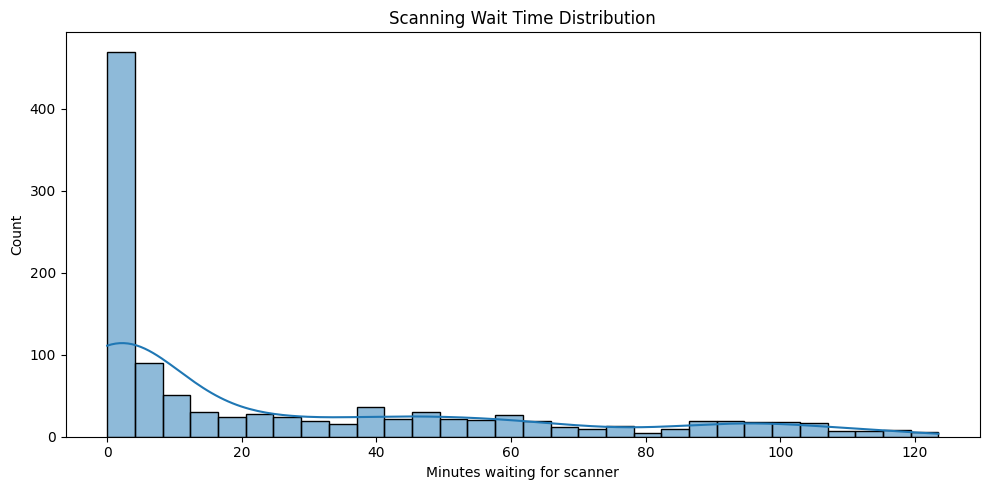

Saved: figures\run_20251212_092421\scan_wait.png


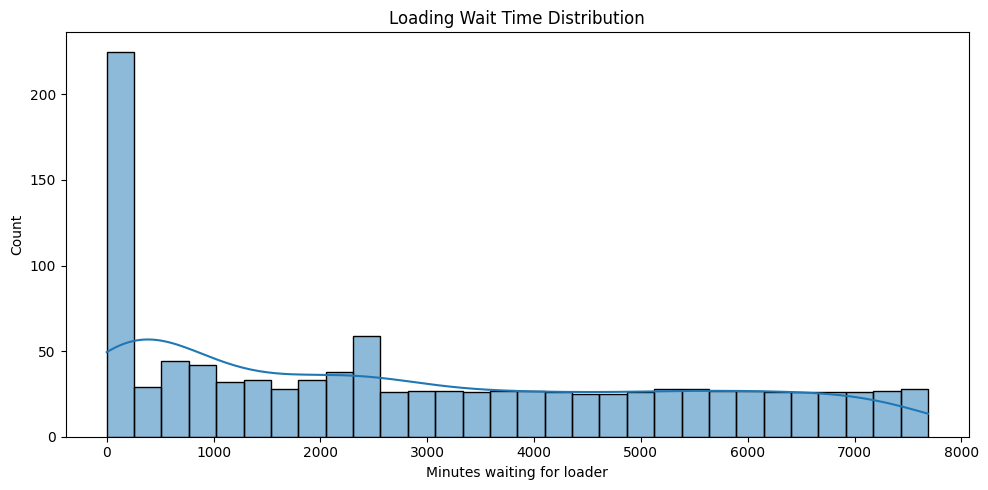

Saved: figures\run_20251212_092421\loading_wait.png


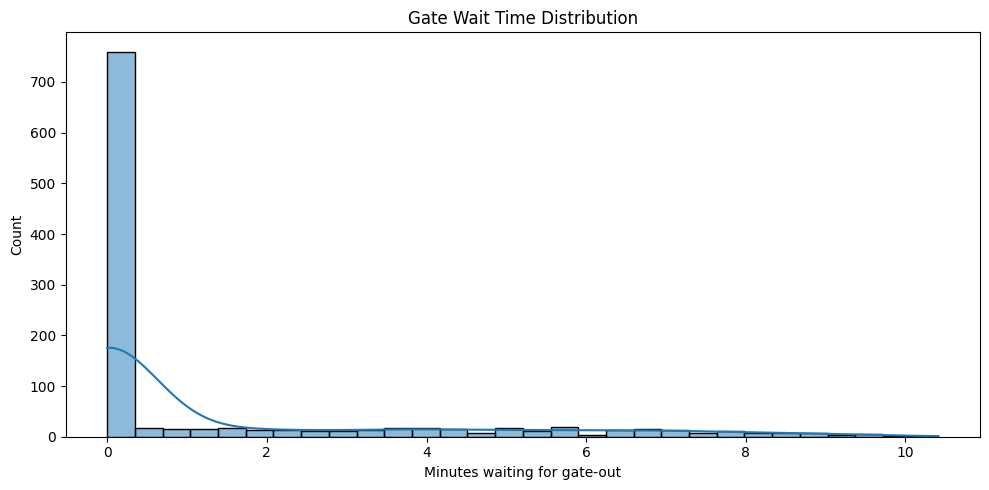

Saved: figures\run_20251212_092421\gate_wait.png


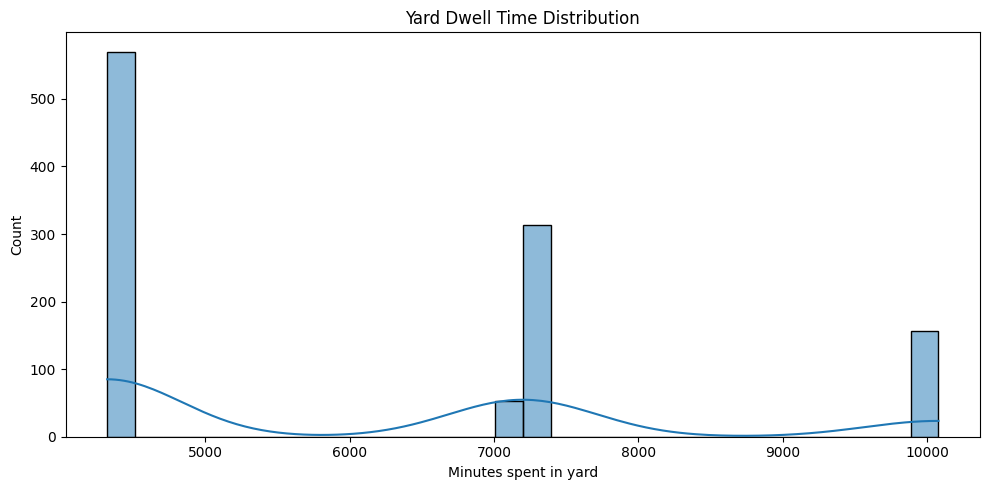

Saved: figures\run_20251212_092421\yard_dwell.png


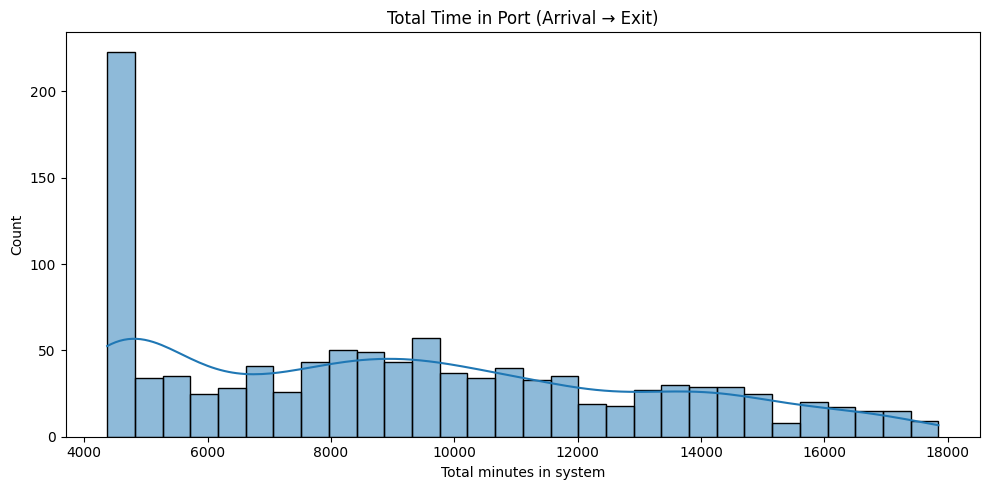

Saved: figures\run_20251212_092421\total_time.png


In [9]:
# -----------------------------------------
# Plot metrics and save figures per run
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df = metrics_to_dataframe()

# Skip if nothing to plot
if df.empty:
    print("No completed containers to plot yet.")
else:
    # Create a per-run folder
    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_metric(df, column, title, xlabel, filename):
        if column not in df.columns:
            print(f"Skipping {column}: column not found.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(df[column], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    plot_metric(df, "scan_wait",
                "Scanning Wait Time Distribution",
                "Minutes waiting for scanner",
                "scan_wait.png")

    plot_metric(df, "loading_wait",
                "Loading Wait Time Distribution",
                "Minutes waiting for loader",
                "loading_wait.png")

    plot_metric(df, "gate_wait",
                "Gate Wait Time Distribution",
                "Minutes waiting for gate-out",
                "gate_wait.png")

    plot_metric(df, "yard_dwell",
                "Yard Dwell Time Distribution",
                "Minutes spent in yard",
                "yard_dwell.png")

    plot_metric(df, "total_time",
                "Total Time in Port (Arrival → Exit)",
                "Total minutes in system",
                "total_time.png")


**What this does**
- Regenerates `df` from completed containers; skips plotting if empty.
- Creates a timestamped folder under `figures/run_YYYYMMDD_HHMMSS` for this run.
- Plots histograms (with KDE) for scan, loading, and gate waits; saves each PNG into the run folder and reports the saved paths.


# Improved Dwell Container Process

In [10]:
# -----------------------------------------
# Run Improved Dwell Simulation (Realistic)
# -----------------------------------------

# Reset metrics for improved run
METRICS_IMPROVED = []

# Custom record function for improved dwell run
def record_metrics_improved(container_id, timestamps):
    METRICS_IMPROVED.append({
        "container_id": container_id,
        **timestamps
    })

# Improved dwell container process (REALISTIC TRUCK + GATE BEHAVIOUR)
def container_process_improved_wrapper(env, container_id, cranes, yard, scanners, loaders, gates):

    t = {}
    t["arrival_time"] = env.now

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry
    yard_req = yard.put(1)
    yield yard_req
    t["yard_entry_time"] = env.now

    # 3. Improved Yard Dwell (Option 2: 2–4 days)
    dwell_time = random.choice([
        2 * 24 * 60, 
        3 * 24 * 60, 
        4 * 24 * 60
    ])
    yield env.timeout(dwell_time)
    t["yard_exit_time"] = env.now

    # 4. Scanning (same logic)
    with scanners.request() as req:
        t["scan_queue_enter"] = env.now
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 5. Truck Loading (now variable & capacity-limited)
    with loaders.request() as req:
        t["loading_queue_enter"] = env.now
        yield req
        t["loading_start"] = env.now
        loading_time = sample_loading_time()     # <-- NEW stochastic service time
        yield env.timeout(loading_time)
        t["loading_end"] = env.now

    yield yard.get(1)    # free yard space

    # 6. Gate-Out (now variable & capacity-limited)
    with gates.request() as req:
        t["gate_queue_enter"] = env.now
        yield req
        t["gate_start"] = env.now
        gate_time = sample_gate_time()          # <-- NEW stochastic service time
        yield env.timeout(gate_time)
        t["exit_time"] = env.now

    # Save metrics
    record_metrics_improved(container_id, t)


# ---------------------------------------------------
# Create environment for improved dwell simulation
# ---------------------------------------------------
env2 = simpy.Environment()

cranes2 = simpy.Resource(env2, capacity=NUM_CRANES)
yard2 = simpy.Container(env2, capacity=YARD_CAPACITY, init=0)
scanners2 = simpy.Resource(env2, capacity=NUM_SCANNERS)
loaders2 = simpy.Resource(env2, capacity=NUM_LOADING_BAYS)
gates2 = simpy.Resource(env2, capacity=NUM_GATE_LANES)

# Improved arrival generator (unchanged)
def arrival_generator_improved(env, cranes, yard, scanners, loaders, gates, stop_time):
    container_id = 0
    while True:
        interarrival = random.expovariate(1/5)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        env.process(
            container_process_improved_wrapper(env, container_id, cranes, yard, scanners, loaders, gates)
        )
        container_id += 1

# Run improved simulation
env2.process(arrival_generator_improved(env2, cranes2, yard2, scanners2, loaders2, gates2, SIM_TIME))
env2.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

print("Improved dwell simulation complete.")


Improved dwell simulation complete.


# Convert improved metrics to dataframe

In [11]:
# -----------------------------------------
# Convert Improved Metrics to DataFrame
# -----------------------------------------

def metrics_to_dataframe_improved():
    if not METRICS_IMPROVED:
        return pd.DataFrame()

    df_improved = pd.DataFrame(METRICS_IMPROVED)

    # Core durations
    df_improved["total_time"] = df_improved["exit_time"] - df_improved["arrival_time"]
    df_improved["yard_dwell"] = df_improved["yard_exit_time"] - df_improved["yard_entry_time"]

    # Correct queue waits (NO references to previous stages)
    df_improved["scan_wait"] = df_improved["scan_start"] - df_improved["scan_queue_enter"]
    df_improved["loading_wait"] = df_improved["loading_start"] - df_improved["loading_queue_enter"]
    df_improved["gate_wait"] = df_improved["gate_start"] - df_improved["gate_queue_enter"]

    # Safety
    for col in ["scan_wait", "loading_wait", "gate_wait"]:
        df_improved[col] = df_improved[col].clip(lower=0)

    return df_improved


# A Peek at the Dataframe

In [12]:
df_improved = metrics_to_dataframe_improved()
df_improved.head(10)

,container_id,arrival_time,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,loading_queue_enter,loading_start,loading_end,gate_queue_enter,gate_start,exit_time,total_time,yard_dwell,scan_wait,loading_wait,gate_wait
0,0,7.539605,7.539605,10.872939,10.872939,2890.872939,2890.872939,2890.872939,2900.872939,2900.872939,2900.872939,2932.311441,2932.311441,2932.311441,2941.598614,2934.059008,2880.0,0.000000,0.000000,0.000000
1,3,22.638746,22.638746,25.972079,25.972079,2905.972079,2905.972079,2905.972079,2915.972079,2915.972079,2915.972079,2948.286537,2948.286537,2948.286537,2958.051173,2935.412427,2880.0,0.000000,0.000000,0.000000
2,4,24.528798,24.528798,27.862132,27.862132,2907.862132,2907.862132,2907.862132,2917.862132,2917.862132,2932.311441,2961.065869,2961.065869,2961.065869,2971.229609,2946.700811,2880.0,0.000000,14.449310,0.000000
3,6,29.962244,29.962244,33.295577,33.295577,2913.295577,2913.295577,2915.972079,2925.972079,2925.972079,2948.286537,2977.405373,2977.405373,2977.405373,2987.202323,2957.240079,2880.0,2.676502,22.314458,0.000000
4,12,61.649078,61.649078,64.982411,64.982411,2944.982411,2944.982411,2944.982411,2954.982411,2954.982411,2961.065869,2982.023008,2982.023008,2987.202323,2995.139771,2933.490693,2880.0,0.000000,6.083457,5.179315
5,14,72.513407,72.513407,75.846740,75.846740,2955.846740,2955.846740,2955.846740,2965.846740,2965.846740,2977.405373,3004.261030,3004.261030,3004.261030,3013.026022,2940.512615,2880.0,0.000000,11.558632,0.000000
6,18,99.264442,99.264442,102.597775,102.597775,2982.597775,2982.597775,2982.597775,2992.597775,2992.597775,2992.597775,3022.354850,3022.354850,3022.354850,3029.390924,2930.126483,2880.0,0.000000,0.000000,0.000000
7,22,123.832309,123.832309,127.165643,127.165643,3007.165643,3007.165643,3007.165643,3017.165643,3017.165643,3017.165643,3050.744047,3050.744047,3050.744047,3059.558294,2935.725985,2880.0,0.000000,0.000000,0.000000
8,28,134.836264,134.836264,138.169597,138.169597,3018.169597,3018.169597,3018.169597,3028.169597,3028.169597,3028.169597,3056.670089,3056.670089,3059.558294,3066.265612,2931.429348,2880.0,0.000000,0.000000,2.888205
9,32,140.642861,140.642861,143.976194,143.976194,3023.976194,3023.976194,3028.169597,3038.169597,3038.169597,3056.670089,3082.619020,3082.619020,3082.619020,3090.807615,2950.164755,2880.0,4.193403,18.500492,0.000000


# Side-by-Side Comparison Plots

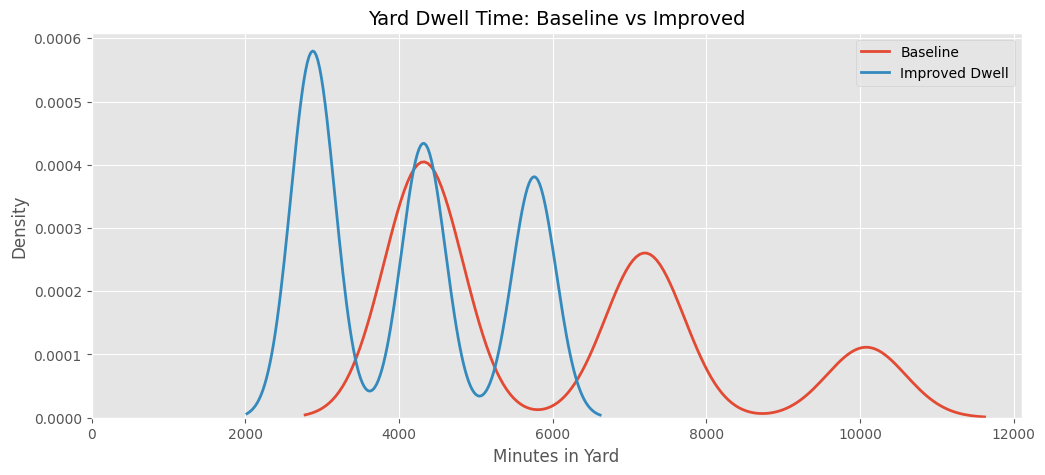

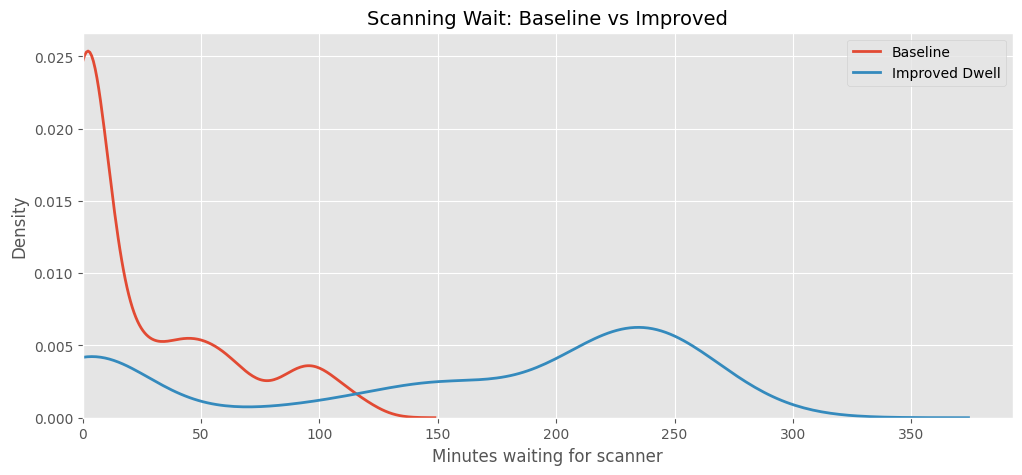

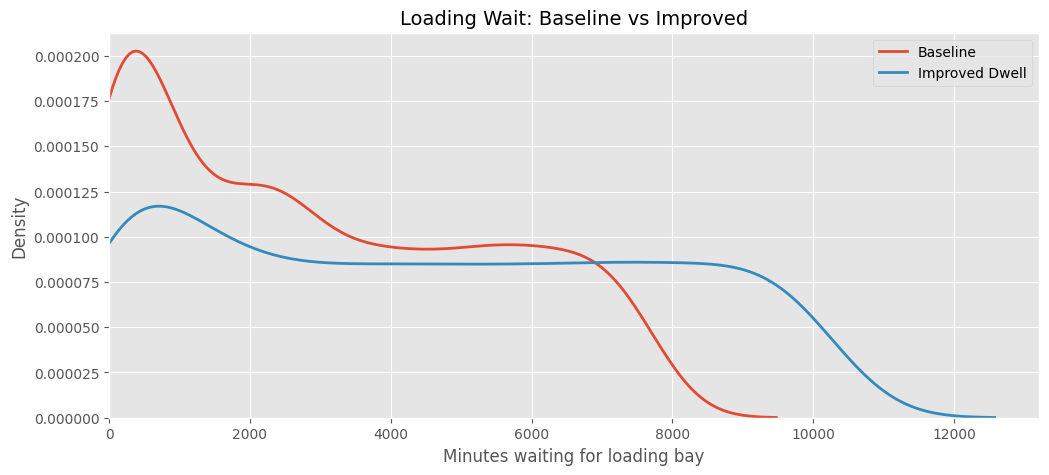

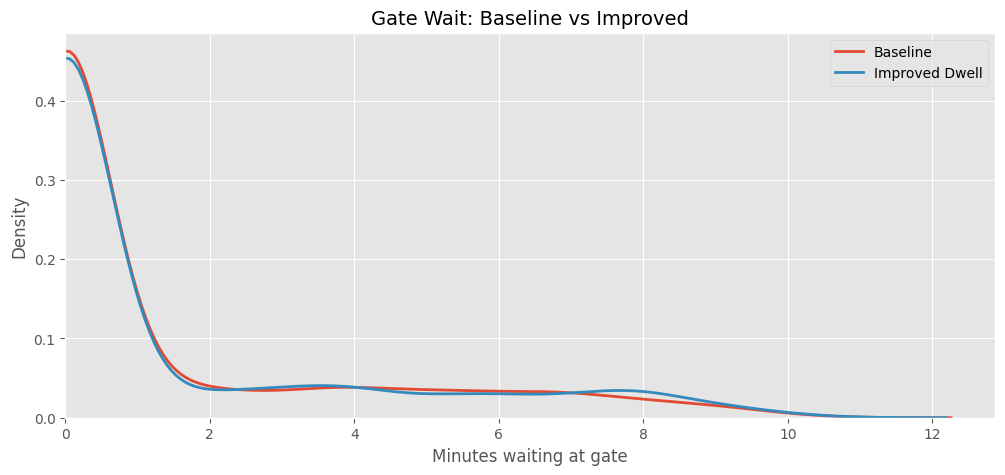

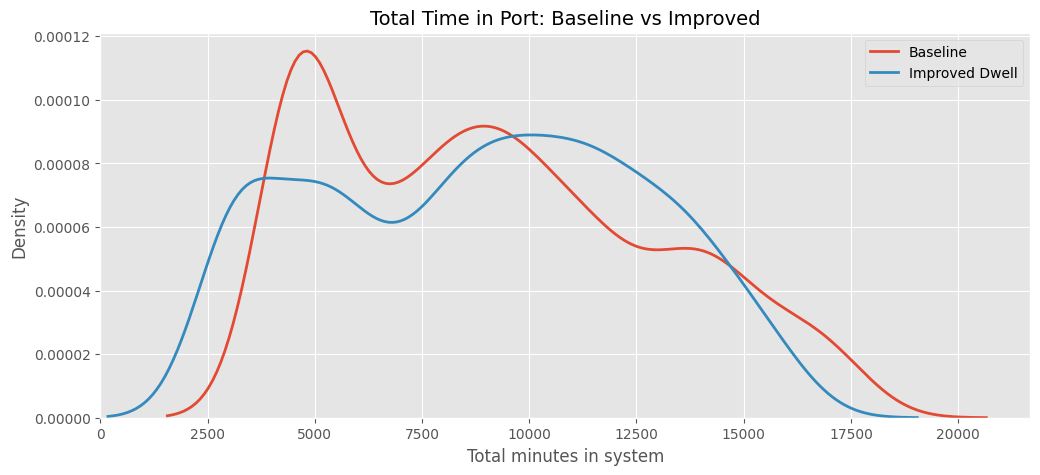

In [13]:
# -----------------------------------------
# Compare Baseline vs Improved Dwell
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

def compare_distributions(df1, df2, column, title, xlabel):
    if column not in df1.columns or column not in df2.columns:
        print(f"Skipping {column}: missing in dataframe.")
        return
    
    plt.figure(figsize=(12,5))
    
    # Clip KDE to non-negative domain (the correct domain for waits)
    sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
    sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.xlim(left=0)   # Force the X-axis to start at 0
    plt.legend()
    plt.show()



# ------- Required comparisons -------

compare_distributions(df, df_improved,
                      "yard_dwell",
                      "Yard Dwell Time: Baseline vs Improved",
                      "Minutes in Yard")

compare_distributions(df, df_improved,
                      "scan_wait",
                      "Scanning Wait: Baseline vs Improved",
                      "Minutes waiting for scanner")

compare_distributions(df, df_improved,
                      "loading_wait",
                      "Loading Wait: Baseline vs Improved",
                      "Minutes waiting for loading bay")

compare_distributions(df, df_improved,
                      "gate_wait",
                      "Gate Wait: Baseline vs Improved",
                      "Minutes waiting at gate")

compare_distributions(df, df_improved,
                      "total_time",
                      "Total Time in Port: Baseline vs Improved",
                      "Total minutes in system")


### **Comparison: Baseline vs Improved Yard Dwell**

These plots compare the baseline simulation and the improved-dwell simulation.

The goal is to show how reducing yard dwell time affects:

- overall throughput  
- queue lengths  
- system congestion  
- end-to-end transit time  



#### **1. Yard Dwell**
This should show a significant left-shift (shorter dwell times).

#### **2. Scanning Wait**
Reduced yard congestion allows containers to reach scanning earlier.

#### **3. Loading Wait**
Lower yard occupancy improves container accessibility for loading.

#### **4. Gate Wait**
Gate-out is fast, but improvements upstream reduce peaks.

#### **5. Total Time in System**
This is the most important KPI —  
a large reduction here validates operational impact.

These will form the graphs used in the report and presentation.


# Compute Numerical Improvements

In [14]:
# -----------------------------------------
# Numerical Performance Improvements
# -----------------------------------------

def percentage_change(before, after):
    """Percent reduction; handles zero to avoid divide-by-zero warnings."""
    # Normalize to plain floats to avoid np.float64 in output.
    before = float(before)
    after = float(after)
    if before == 0:
        if after == 0:
            return 0.0
        return float('nan')
    return float(round(((before - after) / before) * 100, 2))

results = {}

# Mean values
results["Mean Total Time Reduction (%)"] = percentage_change(
    df["total_time"].mean(),
    df_improved["total_time"].mean()
)

results["Mean Yard Dwell Reduction (%)"] = percentage_change(
    df["yard_dwell"].mean(),
    df_improved["yard_dwell"].mean()
)

results["Mean Scanning Wait Reduction (%)"] = percentage_change(
    df["scan_wait"].mean(),
    df_improved["scan_wait"].mean()
)

results["Mean Loading Wait Reduction (%)"] = percentage_change(
    df["loading_wait"].mean(),
    df_improved["loading_wait"].mean()
)

results["Mean Gate Wait Reduction (%)"] = percentage_change(
    df["gate_wait"].mean(),
    df_improved["gate_wait"].mean()
)

results


{'Mean Total Time Reduction (%)': 3.16,
 'Mean Yard Dwell Reduction (%)': 32.68,
 'Mean Scanning Wait Reduction (%)': -473.1,
 'Mean Loading Wait Reduction (%)': -53.24,
 'Mean Gate Wait Reduction (%)': -4.62}

### **Numerical Performance Improvements**

This table quantifies how much performance improves under the reduced dwell policy.

We measure:

- average total time in the port  
- average yard dwell time  
- average scanning wait  
- average loading wait  
- average gate wait  

Each is expressed as a **percentage reduction** relative to baseline.

This forms the core of your optimisation results for the report.
